# Importing the files and libraries required

In [ ]:
#Upload both KSA east and west coastlines
from google.colab import files
files.upload()

In [2]:
import matplotlib.pyplot as plt
import numpy as np      
import pandas as pd
import itertools
import math
import random
from mpmath import power, fadd, fsub, fdiv,fmul, mpf, fabs, fsum, hypot
import heapq
import geopy.distance
import seaborn as sns

sns.set_style('darkgrid')

In [3]:
ksaDataFrame = pd.read_csv('ksa-east.csv')

In [4]:
ksaEast = pd.read_csv('ksa-east.csv')
ksaWest = pd.read_csv('ksa-west.csv')

In [5]:
len(ksaEast)

41969

In [6]:
len(ksaWest)

80358

# **Define classes for coordinates and Segment**

In [7]:
class CoOrdinates:
  def __init__(self, x, y):
    self.x = x
    self.y = y

In [8]:
class Segment:
  def __init__(self, segment, trend):
    self.segment = segment
    self.trend = trend

# **Split The Coordinates into monotonic trended Segments:**

In [9]:
def mergeFirstAndLastIfAllowed(segmentsList):
  firstSegment = segmentsList[0]
  lastSegment = segmentsList[-1]

  if firstSegment.trend == lastSegment.trend:
    increaseCase = firstSegment.trend == 'Increasing' and firstSegment.segment[-1].x > lastSegment.segment[0].x
    decreaseCase = firstSegment.trend == 'Decreasing' and firstSegment.segment[-1].x < lastSegment.segment[0].x
    if increaseCase or decreaseCase:
      firstSegment.segment = lastSegment.segment + firstSegment.segment
      segmentsList.pop()
  
  return segmentsList



In [10]:
def divideIntoSegments(ksaDataFrame):
  segmentsList = []
  currentSegment = []
  trend = 'Constant'

  for idx, row in ksaDataFrame.iterrows():
    x, y = row['X'], row['Y']

    if idx == 0:
      currentSegment.append(CoOrdinates(x,y))
      prevX = x
      continue
    
    breakingDecreasingTrend = (x >= prevX) and trend == 'Decreasing'
    breakingIncreasingTrend = (x <= prevX) and trend == 'Increasing'

    if breakingDecreasingTrend or breakingIncreasingTrend:
      copiedSegment = currentSegment.copy()
      segmentsList.append(Segment(copiedSegment, trend))
      trend = 'Constant'
      currentSegment = []
    
    elif x > prevX:
      trend = 'Increasing'
    
    else:
      trend = 'Decreasing'
    
    currentSegment.append(CoOrdinates(x,y))
    prevX = x
  
  
  if trend != 'Constant':
    copiedSegment = currentSegment.copy()
    segmentsList.append(Segment(copiedSegment, trend))

  segmentsList = mergeFirstAndLastIfAllowed(segmentsList)

  return segmentsList 




In [11]:
segmentsList = divideIntoSegments(ksaDataFrame)

# Is Monotonic (Tester Function for splitting the segement)

In [ ]:
def isMonotonic(segment, trend):
  for i in range(1, len(segment)):
    if trend == 'Increasing':
      if segment[i].x < segment[i-1].x:
        return False
    
    if trend == 'Decreasing':
      if segment[i].x > segment[i-1].x:
        return False

  return True

# **Distance between Two Points**

In [12]:
def distanceBetweenTwoPoints(p1, p2):
  return math.sqrt(((p1.x-p2.x)** 2) + ((p1.y-p2.y)** 2))

# **Merge two decreasing Trended Segments by eliminating the points in the middle**

In [13]:
# Distance Matrix
def minDistanceRemovedDecreasing(segment1, segment2):
  n,m = len(segment1), len(segment2)

  distanceMatrix = [[0 for _ in range(m)] for _ in range(n)]

  for i in range(n):
    for j in range(m-1, -1, -1):
      if i == 0 or j == m-1:
        continue
      
      if segment1[i].x > segment2[j].x:
        distanceMatrix[i][j] = 0
      
      else:
        #Remove End from Segment1
        ch1 = distanceMatrix[i-1][j] + distanceBetweenTwoPoints(segment1[i-1], segment1[i])

        #Remove Start from Segment2
        ch2 = distanceMatrix[i][j+1] + distanceBetweenTwoPoints(segment2[j], segment2[j+1])


        distanceMatrix[i][j] = min(ch1, ch2)
  
  return distanceMatrix



# **Merge two Increasing Trended Segments by eliminating the points in the middle**

In [14]:
# Distance Matrix Increasing
def minDistanceRemovedIncreasing(segment1, segment2):
  n,m = len(segment1), len(segment2)

  distanceMatrix = [[0 for _ in range(m)] for _ in range(n)]

  for i in range(n):
    for j in range(m-1, -1, -1):
      if i == 0 or j == m-1:
        continue
      
      if segment1[i].x < segment2[j].x:
        distanceMatrix[i][j] = 0
      
      else:
        #Remove End from Segment1
        ch1 = distanceMatrix[i-1][j] + distanceBetweenTwoPoints(segment1[i-1], segment1[i])

        #Remove Start from Segment2
        ch2 = distanceMatrix[i][j+1] + distanceBetweenTwoPoints(segment2[j], segment2[j+1])


        distanceMatrix[i][j] = min(ch1, ch2)
  
  return distanceMatrix



# **BackTrack after Building the distance Matrix**

In [15]:
def backTrack(distanceMatrix):
  n = len(distanceMatrix)
  m = len(distanceMatrix[0])

  i, j = n-1, 0

  while True:
    if distanceMatrix[i][j] == 0:
      if i == 0: i-=1
      if j == m-1: j+=1

      return (i, j)

    poss1, poss2 = [float('inf')]*2

    poss1 = distanceMatrix[i-1][j]
    poss2 = distanceMatrix[i][j+1]

    if poss1 < poss2:
      i-=1
    else:
      j+=1

# **Merge Possible Segments and get New Segments List**

In [16]:
def mergePossibleSegments(segmentsList, mergeFactor):
  newSegmentsList = []


  currentSegment = segmentsList[0].segment
  currentTrend = segmentsList[0].trend

  for i in range(1, len(segmentsList)):
    segment = segmentsList[i].segment
    trend = segmentsList[i].trend

    if trend == currentTrend:
      if trend == 'Decreasing':
        distanceMatrix = minDistanceRemovedDecreasing(currentSegment, segment)
      
      elif trend == 'Increasing':
        distanceMatrix = minDistanceRemovedIncreasing(currentSegment, segment)

      if distanceMatrix[-1][0] < mergeFactor:
        endIdx, startIdx = backTrack(distanceMatrix)
        currentSegment = currentSegment[:endIdx+1] + segment[startIdx:]
        continue
      
    newSegmentsList.append(Segment(currentSegment, currentTrend))
    currentSegment = segment
    currentTrend = trend
  
  newSegmentsList.append(Segment(currentSegment, currentTrend))

  return newSegmentsList

In [17]:
newSegments = mergePossibleSegments(segmentsList, 300)

# Delete Segments whose distance is less than distance Parameter and length is less than minLength

In [18]:
def distanceOfSegment(segment):
  distance = 0
  for i in range(1, len(segment)):
    distance += distanceBetweenTwoPoints(segment[i], segment[i-1])
  
  return distance

In [19]:
# Ignore Small segments whose distance is less than the distance parameter
def ignoreSmallSegments(segmentsList, distanceParameter, minLength):
  newSegmentsList = []

  for segment in segmentsList:
    if len(segment.segment) >= minLength and distanceOfSegment(segment.segment) > distanceParameter:
      newSegmentsList.append(segment)
  
  return newSegmentsList

In [20]:
segmentsListAfterIgnoringSmallSegments = ignoreSmallSegments(newSegments, 50, 10)

In [21]:
print(len(segmentsListAfterIgnoringSmallSegments))

439


# Merge Again

In [22]:
newSegmentsOne = mergePossibleSegments(segmentsListAfterIgnoringSmallSegments, 300)

In [23]:
print(len(newSegmentsOne))

349


# Pack Everything

1. Given the dataFrame of co-ordinates, split into monotonic trended segments
2. Merge segments with removed Distance less than merge Factor.
3. Delete Segments with distance less than the distance parameter.
4. Merge the new  segments list again.
5. Return the final segments list for use.

In [24]:
def finalSegmentsList(dataFrame, mergeFactor, distanceFactor, minLength):
  dividedSegments = divideIntoSegments(dataFrame)
  firstMergeSegments = mergePossibleSegments(dividedSegments, mergeFactor)
  listWithDeletedSegments = ignoreSmallSegments(firstMergeSegments, distanceFactor, minLength)
  # secondMergeSegments = mergePossibleSegments(listWithDeletedSegments, mergeFactor)

  return listWithDeletedSegments

In [25]:
def getFinalRawSegmentsList(segmentsList):
  rawList = []

  for segment in segmentsList:
    if segment.trend == 'Decreasing':
      rawList.append(segment.segment[::-1])
    else:
      rawList.append(segment.segment)
  
  return rawList

In [26]:
def lengthAnalysis(segmentsList):
  lengthHash = {}
  for i in range(len(segmentsList)):
    currlen = len(segmentsList[i])
    if currlen in lengthHash:
      lengthHash[currlen]+=1
    
    else:
      lengthHash[currlen] = 1
  
  for i in sorted(lengthHash.keys()):
    print(i, lengthHash[i])

# Get Final KSA east and west lists (MERGED)

In [27]:
ksaWestList = getFinalRawSegmentsList(finalSegmentsList(ksaWest, 300, 300, 20))
ksaEastList = getFinalRawSegmentsList(finalSegmentsList(ksaEast, 300, 300, 20))

In [28]:
len(ksaWestList)

604

In [29]:
len(ksaEastList)

278

In [30]:
lengthAnalysis(ksaWestList)

20 27
21 15
22 27
23 26
24 16
25 17
26 13
27 14
28 15
29 10
30 11
31 17
32 10
33 13
34 10
35 9
36 18
37 13
38 10
39 9
40 11
41 10
42 11
43 8
44 7
45 5
46 15
47 7
48 3
49 10
50 5
51 2
52 8
53 11
54 4
55 5
56 5
57 6
58 5
59 5
60 6
61 5
62 5
63 5
64 3
65 6
66 5
67 3
68 3
69 3
70 1
71 3
72 1
73 1
74 2
75 2
76 2
77 6
78 1
79 1
80 3
82 6
83 1
85 1
86 1
87 1
90 3
91 3
93 1
94 2
95 2
96 1
97 1
98 1
100 1
101 2
102 1
103 2
104 1
105 2
106 3
107 1
109 1
110 2
111 2
114 2
117 1
118 2
119 1
124 3
125 1
129 1
131 2
132 3
138 2
139 1
141 1
142 1
147 1
149 1
153 2
154 1
155 2
156 1
158 2
162 2
169 2
172 1
173 1
175 1
178 1
181 1
197 1
199 1
200 1
204 1
234 1
253 1
258 1
300 1
317 1
371 1
387 1
581 1


In [31]:
lengthAnalysis(ksaEastList)

20 10
21 12
22 4
23 8
24 6
25 8
26 2
27 6
28 2
29 3
30 3
31 8
32 4
33 6
34 2
35 4
36 7
37 2
38 2
39 6
40 3
41 4
42 5
43 3
44 4
45 2
46 3
47 2
48 4
49 3
50 2
51 1
53 3
54 4
55 1
57 3
58 2
59 2
60 1
61 3
62 1
64 3
65 3
66 2
67 3
68 2
71 3
72 4
73 1
74 2
75 1
77 3
78 1
80 1
81 1
82 1
83 1
87 1
89 1
91 1
92 1
93 1
94 3
95 1
97 1
98 5
99 1
101 1
104 2
109 2
110 1
112 1
115 3
116 1
117 1
119 2
121 2
124 1
128 2
129 2
130 1
131 1
134 2
137 1
138 1
141 1
144 1
146 1
150 1
158 1
162 1
170 1
173 1
175 1
177 1
178 1
179 1
191 1
196 1
202 1
204 1
207 1
211 1
225 1
232 1
237 1
243 1
247 1
256 1
258 1
262 1
290 1
304 1
305 1
310 1
327 1
349 1
393 1
407 1
408 1
425 1
427 1
446 1
532 1
565 1
608 1
679 1


In [32]:
eastAndWestList = ksaEastList+ ksaWestList
len(eastAndWestList)

882

## Fractal Dimension


# Get a,b,c,d lists for FIF method

In [33]:
'''
Get the ai values of the IFS
'''
def getAValues(segment):
  aValues = []
  xn = segment[-1].x
  xo = segment[0].x

  denominator = fsub(xn, xo)

  for i in range(1,len(segment)):
    xi = segment[i].x
    xi1 = segment[i-1].x

    numerator = fsub(xi, xi1)

    ai = fdiv(numerator, denominator)

    aValues.append(ai)
  
  return aValues

In [34]:
def getBValues(n):
  return [0 for _ in range(n)]

In [35]:
def getCValues(segment, dValues):
  cValues = []
  xn = segment[-1].x
  xo = segment[0].x
  fn = segment[-1].y
  fo = segment[0].y

  fno = fsub(fn, fo)

  denominator = fsub(xn, xo)

  for i in range(1, len(segment)):
    fi = segment[i].y
    fi1 = segment[i-1].y

    dn = dValues[i-1]

    numerator1 = fsub(fi, fi1)
    numerator2 = fmul(dn, fno)

    numerator = fsub(numerator1, numerator2)

    cValues.append(fdiv(numerator, denominator))
  
  return cValues

In [36]:
def getDValues(n):
  dValues = [0.9, 0.1]

  for i in range(n-2):
    dValues.append(0.0006)
  
  return dValues

In [37]:
def getEValues(segment):
  eValues = []
  xn = segment[-1].x
  xo = segment[0].x

  denominator = fsub(xn, xo)

  for i in range(1,len(segment)):
    xi = segment[i].x
    xi1 = segment[i-1].x

    numerator1 = fmul(xi1, xn)
    numerator2 = fmul(xo, xi)

    numerator = fsub(numerator1, numerator2)

    eValues.append(fdiv(numerator, denominator))

  return eValues

In [38]:
def getFValues(segment, dValues):
  fValues = []
  xn = segment[-1].x
  xo = segment[0].x
  fn = segment[-1].y
  fo = segment[0].y


  denominator = fsub(xn, xo)


  num20 = fmul(xn, fo)
  num21 = fmul(xo, fn)
  num2 = fsub(num20, num21)

  for i in range(1, len(segment)):
    fi = segment[i].y
    fi1 = segment[i-1].y
    
    num10 = fmul(xn, fi1)
    num11 = fmul(xo, fi)
    num1 = fsub(num10, num11)

    dn = dValues[i-1]
    
    finalNum2 = fmul(dn, num2)

    numerator = fsub(num1, finalNum2)

    fValues.append(fdiv(numerator, denominator))
  
  return fValues

# Optimal d Values using Analytical Method from Paper Using IFS to model discrete sequences (Experimental for now, Not finished)



In [39]:
def getMValues(segment):
  aValues = getAValues(segment)
  eValues = getEValues(segment)

  mValues = []
  for i in range(len(segment)-1):
    nValue = (int(fadd(fmul(aValues[i], i), eValues[i]))) % (len(segment)-1)
    mValues.append(nValue)

  return mValues

In [40]:
def getEpsilonNValues(segment):
  epsilonNValues = []
  xn = segment[-1].x
  x0 = segment[0].x

  denominator = fsub(xn, x0)

  for i in range(1, len(segment)):
    xi = segment[i].x
    numerator = fsub(xn, xi)
    epsilonValue = fdiv(numerator, denominator)
    epsilonNValues.append(epsilonValue)
  
  return epsilonNValues

In [41]:
def getANValues(segment,epsilonNValues):
  ANValues = []
  y0 = segment[0].y
  yn = segment[-1].y
  
  for i in range(len(segment)-1):
    yi = segment[i].y
    part21 = fmul(epsilonNValues[i], y0)
    part221 = fsub(1, epsilonNValues[i])
    part22 = fmul(part221, yn)

    part2 = fadd(part21, part22)

    ANValues.append(fsub(yi, part2))
  
  return ANValues

In [42]:
def getBNValues(segment, epsilonNValues, idx, aValues, eValues):
  y1 = segment[idx].y
  y2 = segment[idx+1].y

  BNValues = []
  mValues = getMValues(segment)

  for i in range(len(segment)-1):
    m = mValues[i]
    ym = segment[m].y
    part21 = fmul(epsilonNValues[i], y1)
    part221 = fsub(1, epsilonNValues[i])
    part22 = fmul(part221, y2)
    part2 = fadd(part21, part22)

    BNValues.append(fsub(ym, part2))
  
  return BNValues

In [43]:
def getSumOfASquares(ANValues):
  result = 0
  for i in range(len(ANValues)):
    result = fadd(result, fmul(ANValues[i], ANValues[i]))
  
  return result

In [44]:
def getSumOfANBN(ANValues, BNValues):
  result = 0
  for i in range(len(ANValues)):
    result = fadd(result, fmul(ANValues[i], BNValues[i]))
  
  return result

In [45]:
def getOptimalDValuesAnalytical(segment):
  epsilonNValues = getEpsilonNValues(segment)
  ANValues = getANValues(segment,epsilonNValues)

  sumOfASquares = getSumOfASquares(ANValues)

  dValues = []

  aValues = getAValues(segment)
  eValues = getEValues(segment)

  for i in range(len(segment)-1):
    BNValues = getBNValues(segment, epsilonNValues, i, aValues, eValues)
    sumOfANBN = getSumOfANBN(ANValues, BNValues)

    dValues.append(fdiv(sumOfANBN,sumOfASquares))
  
  return dValues

# Optimal d Values using Geometric Method from Paper Using IFS to model discrete sequences (Experimental for now, Not finished)

In [ ]:
def getA(x1, y1, x2, y2):
  numerator = fsub(y2, y1)
  denominator = fsub(x2, x1)

  if int(denominator) == 0:
    return (1, True)

  return (fdiv(numerator, denominator), False)

In [ ]:
def getC(x1, y1, a):
  part2 = fmul(a, x1)

  return fsub(y1, part2)

In [ ]:
def getNumerator(a, b, c, x0, y0):
  part1 = fmul(a, x0)
  part2 = fmul(b, y0)

  result = fsum([part1, part2, c])

  return fabs(result)

In [ ]:
def getDistanceBwLineAndPoint(point, point1, point2):
  x0, y0 = point.x, point.y
  x1, y1 = point1.x, point2.y
  x2, y2 = point2.x, point2.y

  a = getA(x1, y1, x2, y2)
  b = 0 if a[1] else -1
  c = getC(x1, y1, a[0])

  denominator = hypot(a[0], 1)
  numerator = getNumerator(a[0], b, c, x0, y0)

  return fdiv(numerator, denominator)

In [ ]:
def getMue(segment):
  mue = 0
  point1 = segment[0]
  point2 = segment[-1]

  for i in range(1, len(segment)-1):
    vDistance = getDistanceBwLineAndPoint(segment[i], point1, point2)
    mue = max(mue, vDistance)
  
  return mue

In [ ]:
def getV(segment, idx):
  v = 0

  point1 = segment[idx]
  point2 = segment[idx+1]

  for i in range(len(segment)):
    if i == idx or i == idx+1:
      continue
    
    vDistance = getDistanceBwLineAndPoint(segment[i], point1, point2)
    v = max(v, vDistance)
  
  return v  

In [ ]:
def getOptimalDValues(segment):
  mue = getMue(segment)
  dValues = []

  for idx in range(len(segment)-1):
    v = getV(segment, idx)
    dValues.append(fdiv(v, mue))
  
  return dValues

# Fractal Dimension Expression/ Equation

In [46]:
def fdExpression(aValues, dValues, D):
  expressionResult = 0

  for i in range(len(aValues)):
    aRaised = power(aValues[i], D-1)

    dMulA = fmul(dValues[i], aRaised)

    expressionResult = fadd(expressionResult, dMulA)
  
  return expressionResult

# Find Fractal Dimension D Using Binary Search Algorithm

In [47]:
def findDBinarySearch(segment):
  aValues = getAValues(segment)
  dValues = getDValues(len(segment)-1)


  left, right = 1, 2


  while True:

    mid = fdiv(fadd(left, right), 2)

    fdExpressionValue = fdExpression(aValues, dValues, mid)

    if abs(fdExpressionValue-1) < power(10,-10):
      return mid

    if fdExpressionValue > 1:
      left = mid
    
    else:
      right = mid
    
    if mid == 1 or mid == 2: return 'No solution'

    # print(mid, fdExpressionValue)

In [48]:
def plotGraph(segment, plotTitle):
  xValues = []
  yValues = []

  for point in segment:
    xValues.append(point.x)
    yValues.append(point.y)
  
  plt.figure(figsize=(8,4.8))
  plt.plot(xValues, yValues)
  plt.title(plotTitle + '     Length: ' + str(len(xValues)))
  plt.xticks([])
  plt.yticks([])
  plt.show()
  # plt.savefig(plotTitle + '.png')

In [49]:
def plotGraphKsa(dataFrame, plotTitle):
  xValues = []
  yValues = []

  for idx, row in dataFrame.iterrows():
    xValues.append(row['X'])
    yValues.append(row['Y'])

  plt.figure(figsize=(10, 10), tight_layout=True)
  plt.plot(xValues, yValues)
  plt.title(plotTitle + 'Length: ' + str(len(xValues)))
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.savefig(plotTitle + '.png')

# Maximum Fractal Dimension among subdivisions

In [54]:
maximumFractalDimension = 0
for i in range(len(eastAndWestList)):
  d = findDBinarySearch(eastAndWestList[i])
  maximumFractalDimension = max(maximumFractalDimension, d)

print(maximumFractalDimension)


1.05424678634154


# Random Iteration Algoithm

In [ ]:
def getPValues(n):
  average = 1/n

  last = 1 - ((n-1)*average)

  pValues = []

  for _ in range(n-1):
    pValues.append(average)
  
  pValues.append(last)

  return pValues

In [ ]:
def randomIteration(segment, iters, segmentNumber):
  n = len(segment)-1

  a = getAValues(segment)
  d = getDValues(n)
  b = getBValues(n)
  c = getCValues(segment, d)
  e = getEValues(segment)
  f = getFValues(segment, d)
  p = getPValues(n)

  x = np.linspace(0,5,500)
  y = np.linspace(0,5,500)

  initial = []

  for x,y in zip(x,y):
    initial.append([0,y])
    initial.append([n,y])
    initial.append([x,0])
    initial.append([x,n])

  initial = np.array(initial)

  fig = plt.figure(figsize=(10,10))

  j=0

  for i in range(iters):
    temp = []
    
    for x,y in initial:
      rnd = np.random.choice([i for i in range(n)], p=p)
      nx = a[rnd]*x+b[rnd]*y+e[rnd]
      ny = c[rnd]*x+d[rnd]*y+f[rnd]
      temp.append([nx,ny])

    initial = np.array(temp)


  x,y = initial[:,0],initial[:,1]

  plt.figure(figsize=(8,4.8))
  plt.scatter(x, y, s=1)
  plt.title('Attractor Generated by Random Iteration For segment' + str(segmentNumber))
  plt.xticks([])
  plt.yticks([])
  plt.show()

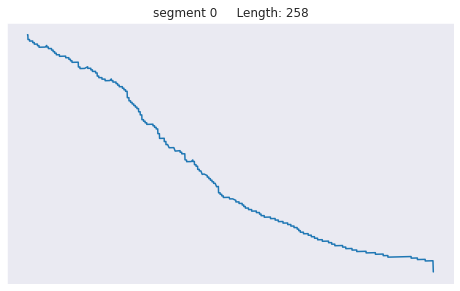

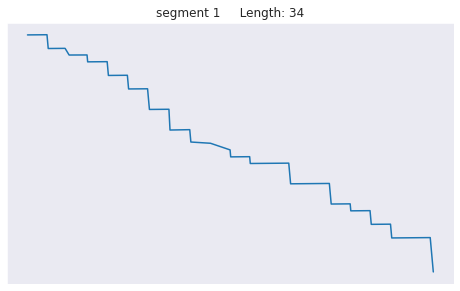

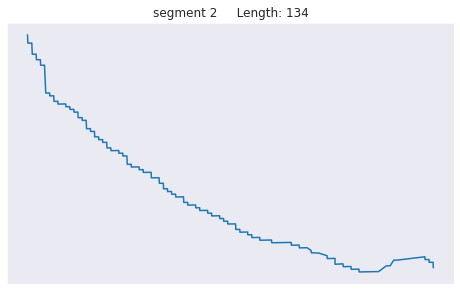

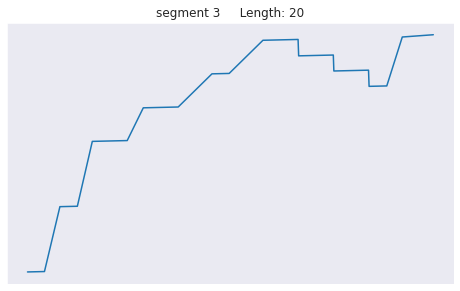

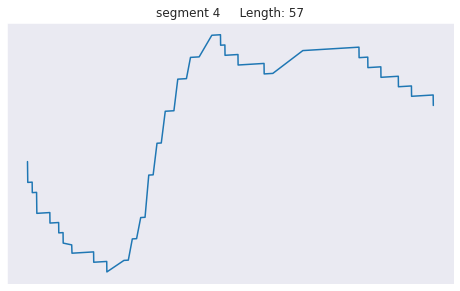

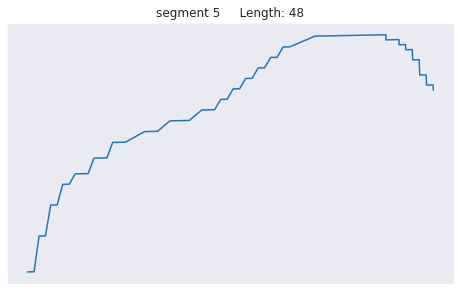

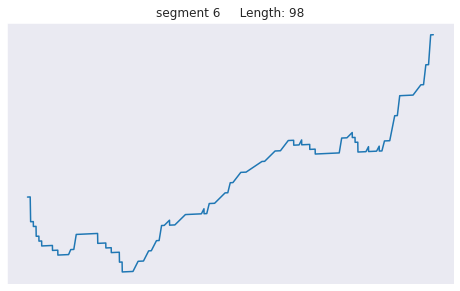

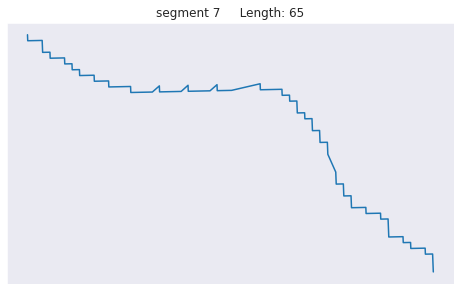

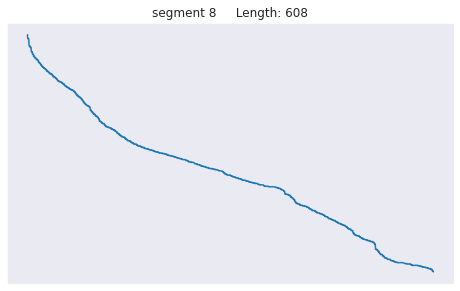

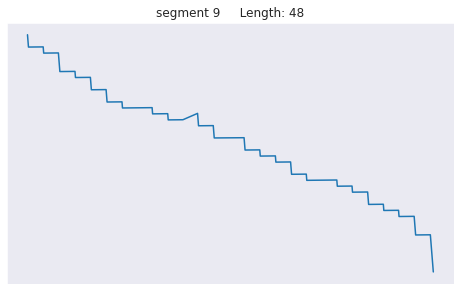

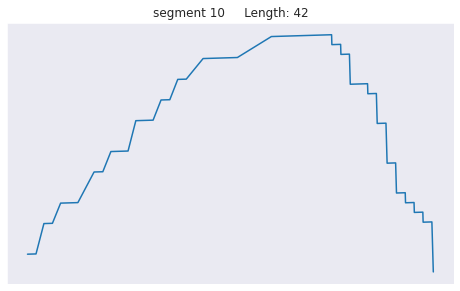

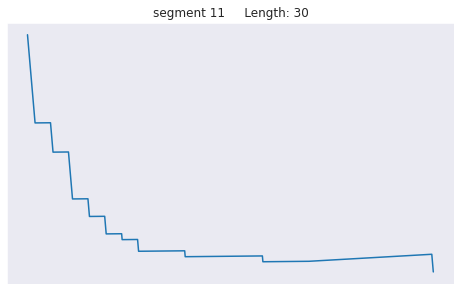

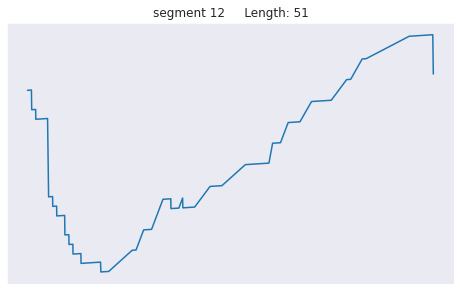

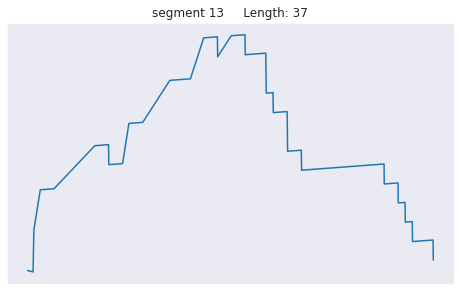

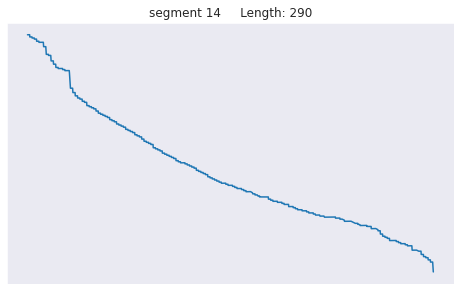

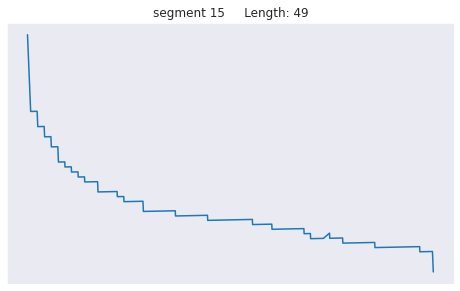

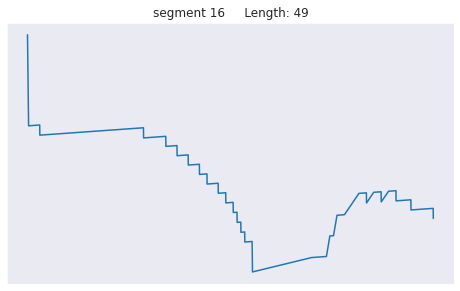

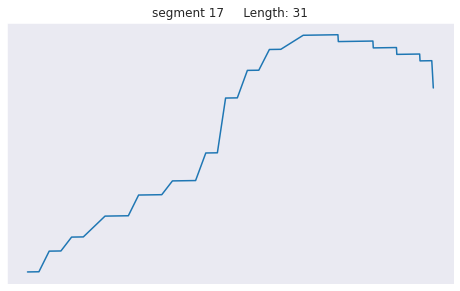

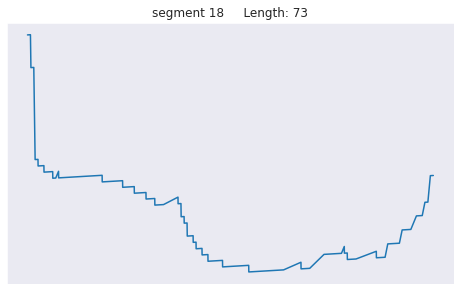

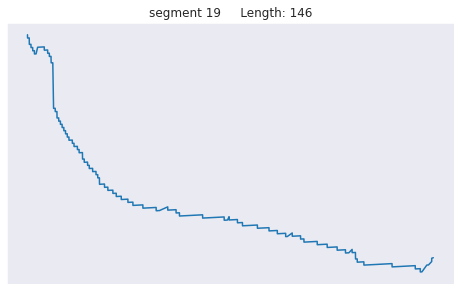

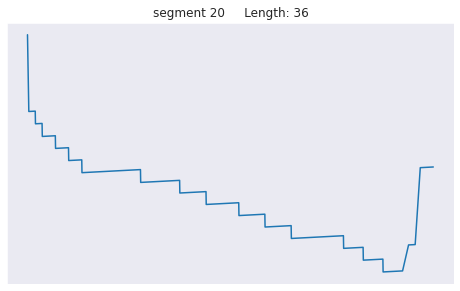

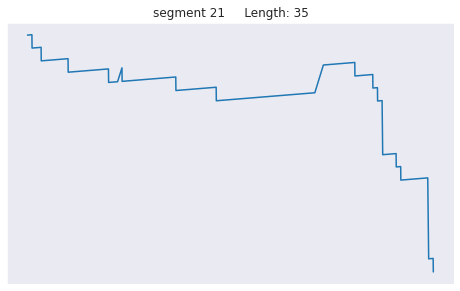

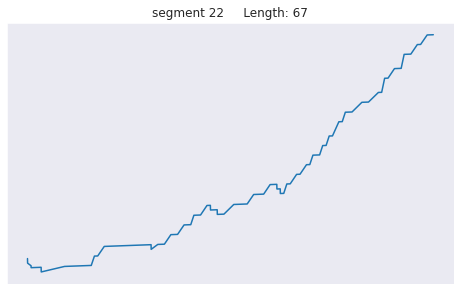

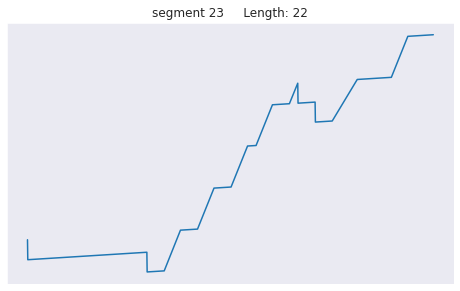

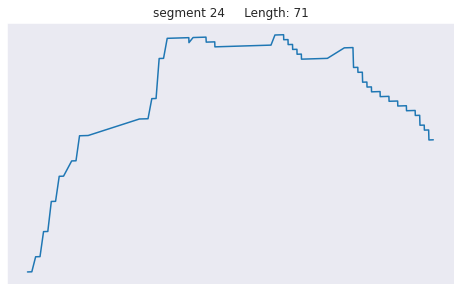

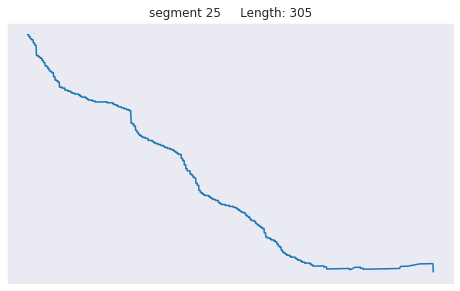

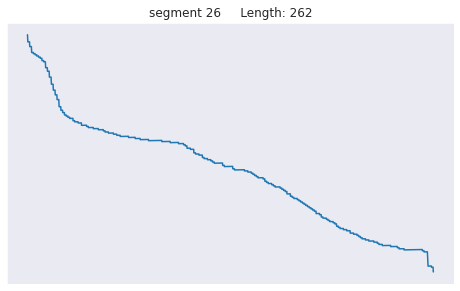

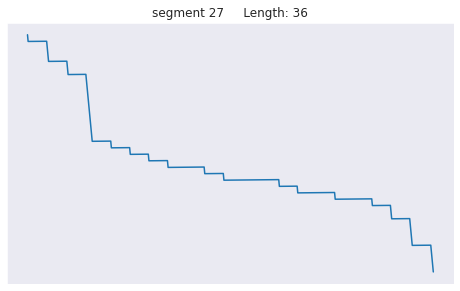

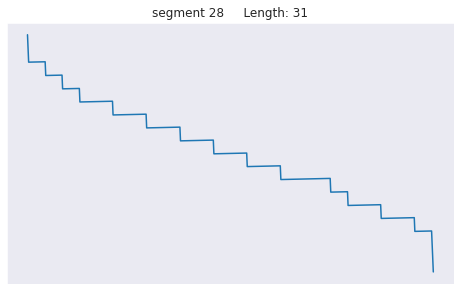

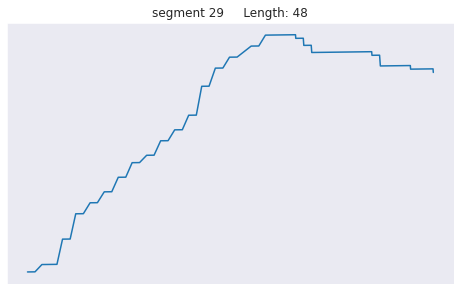

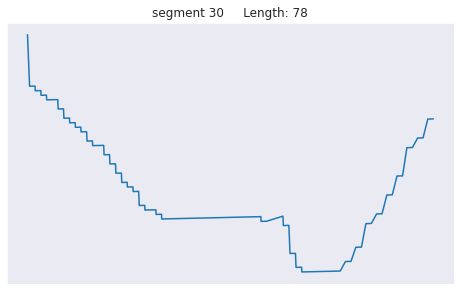

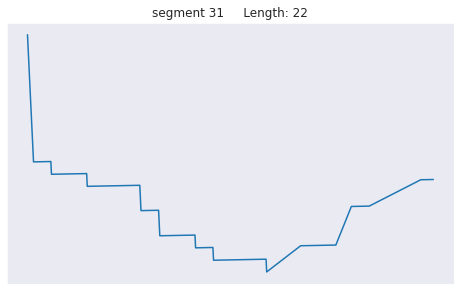

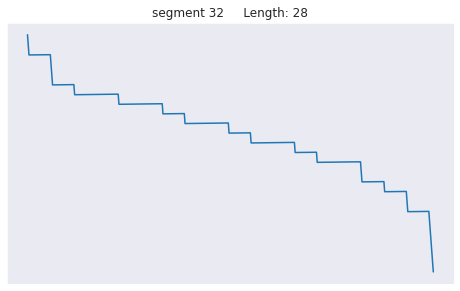

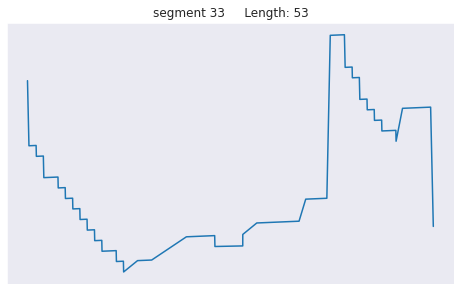

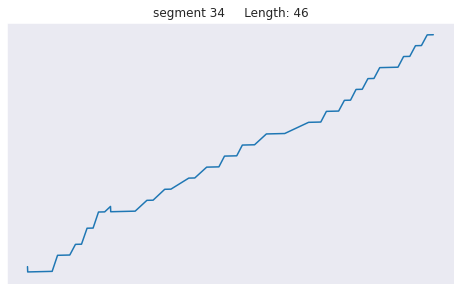

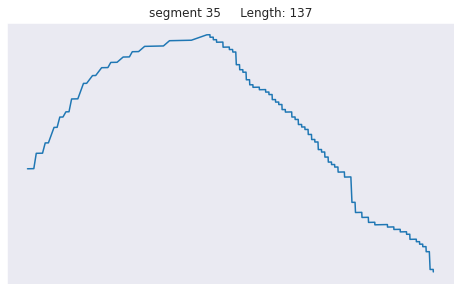

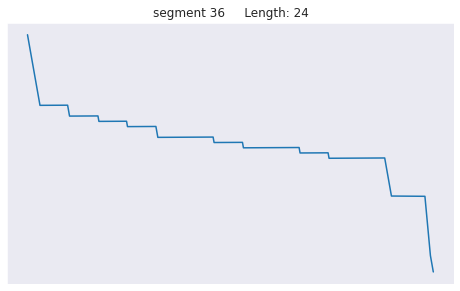

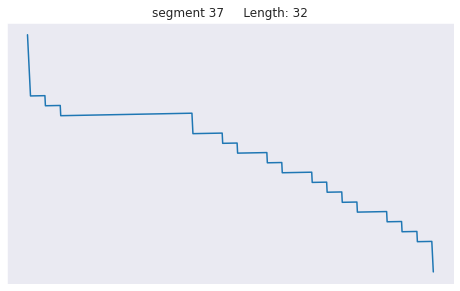

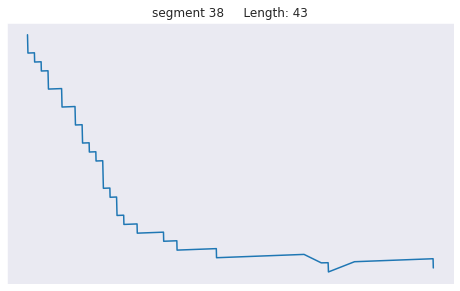

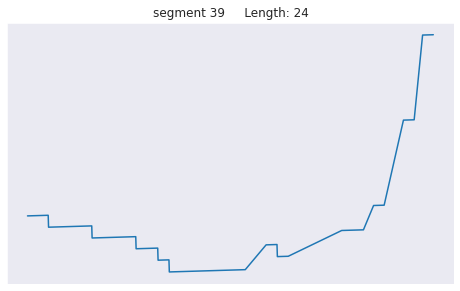

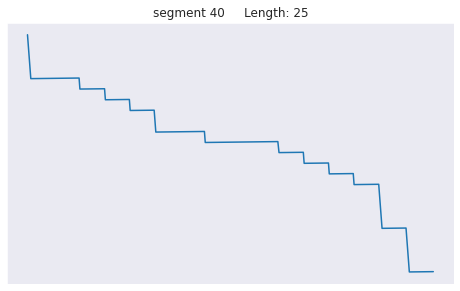

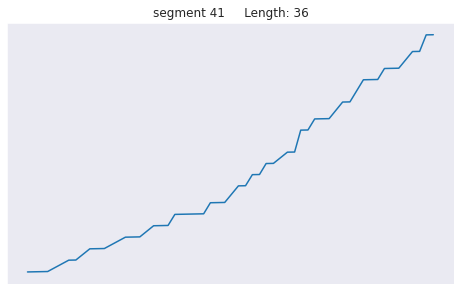

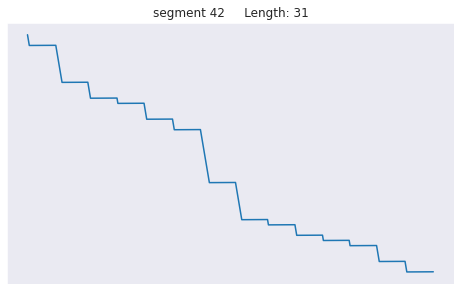

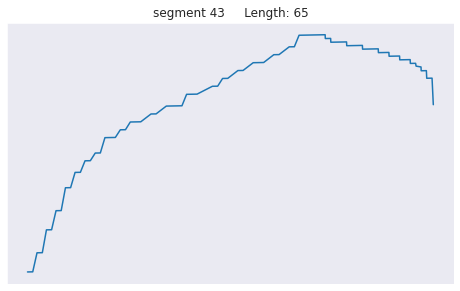

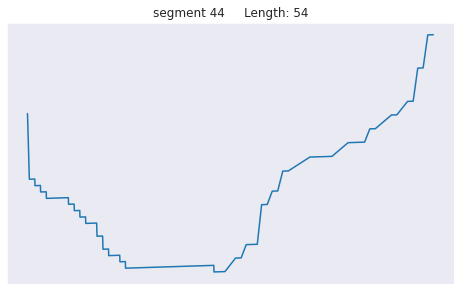

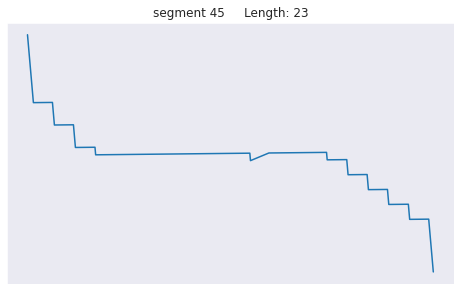

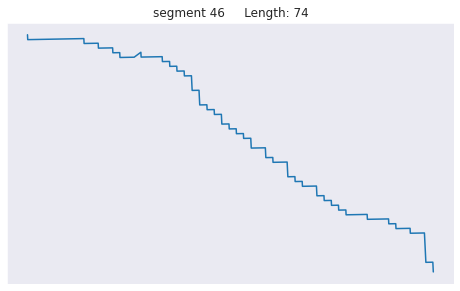

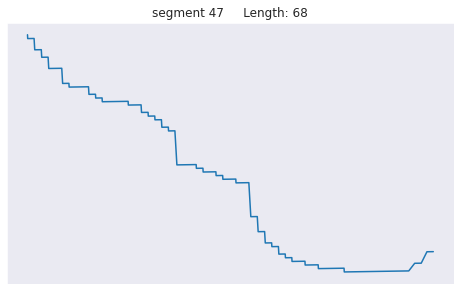

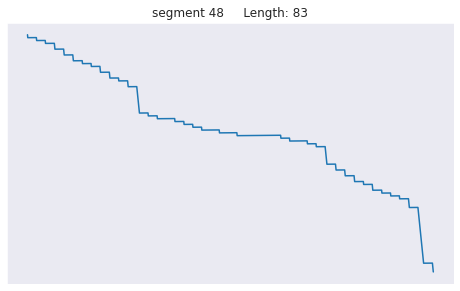

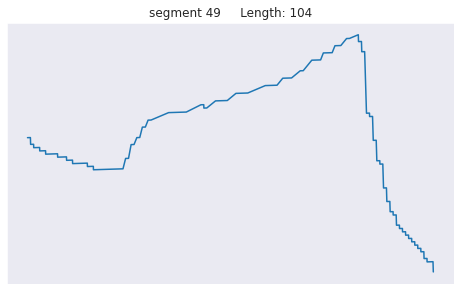

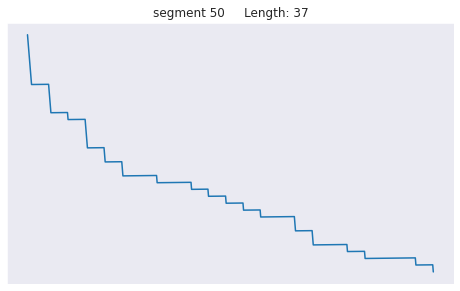

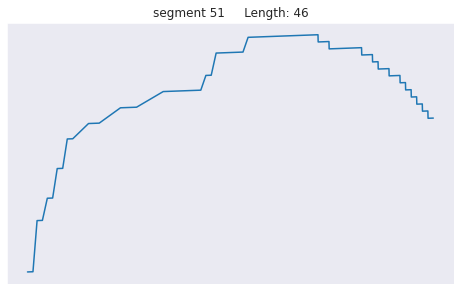

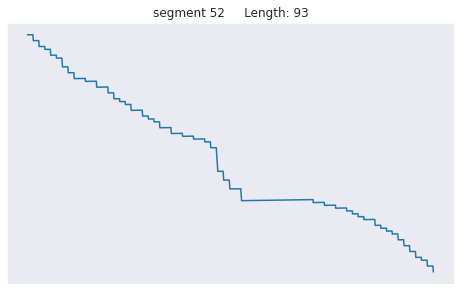

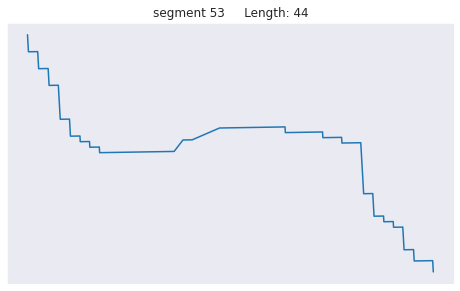

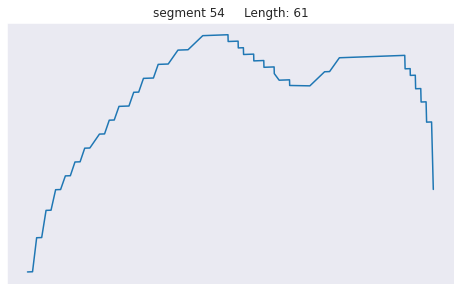

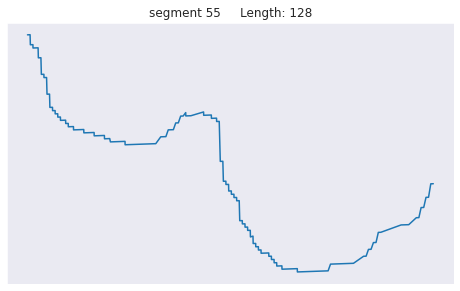

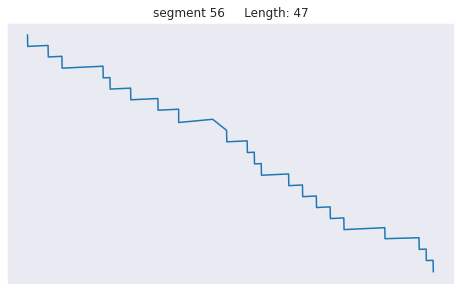

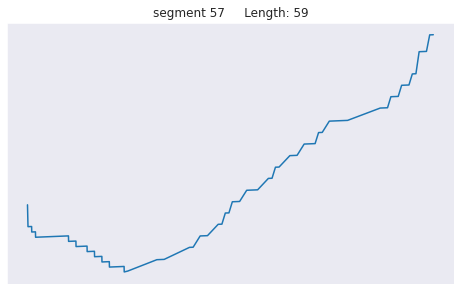

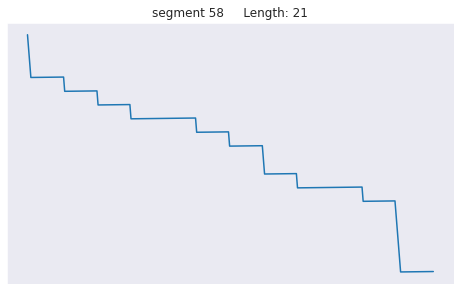

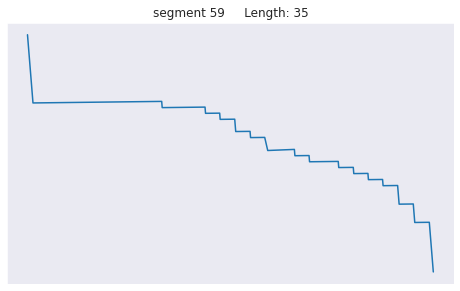

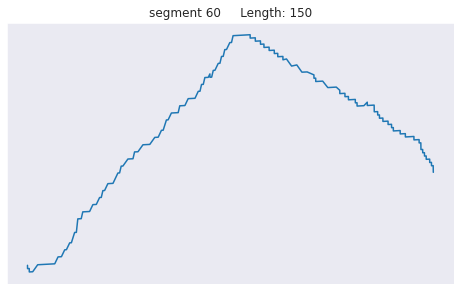

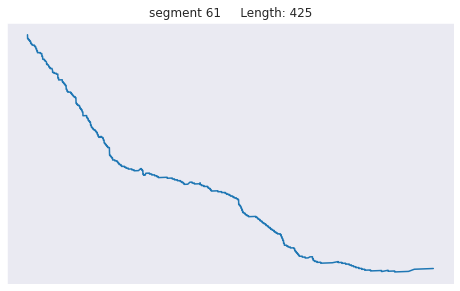

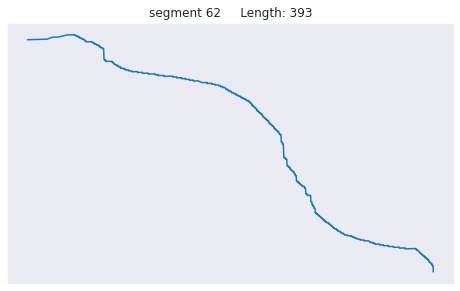

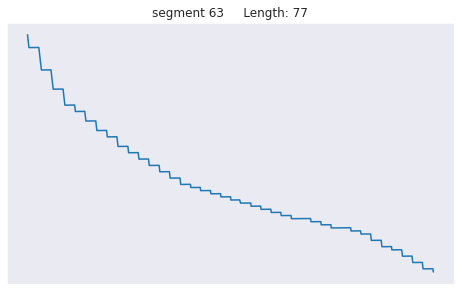

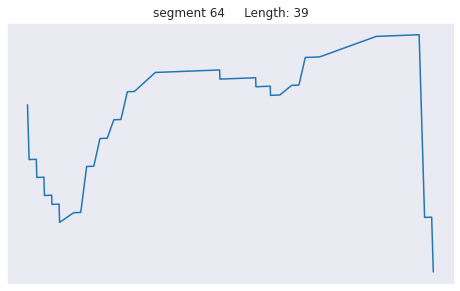

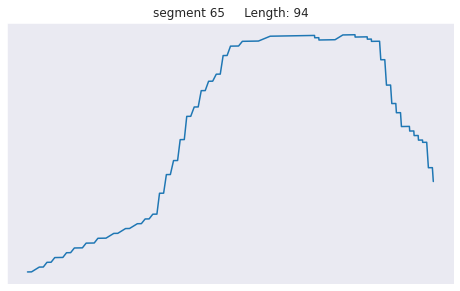

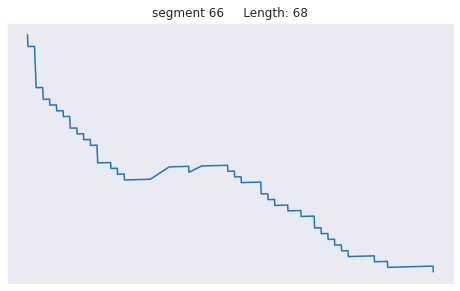

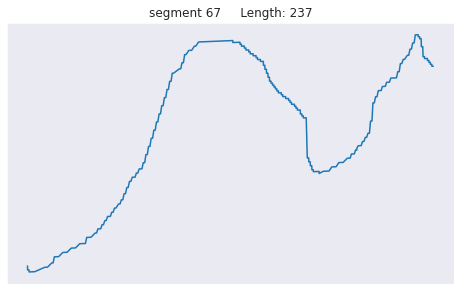

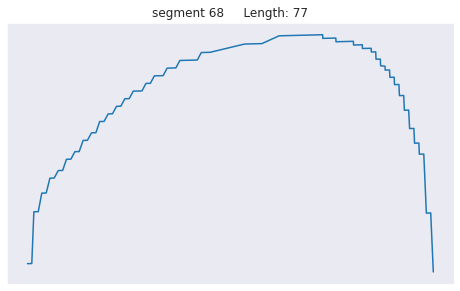

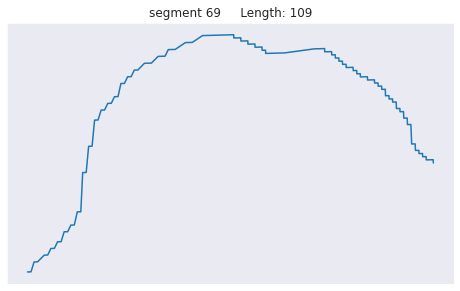

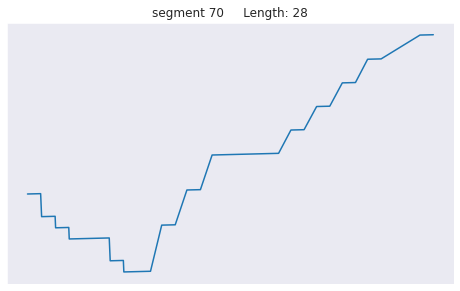

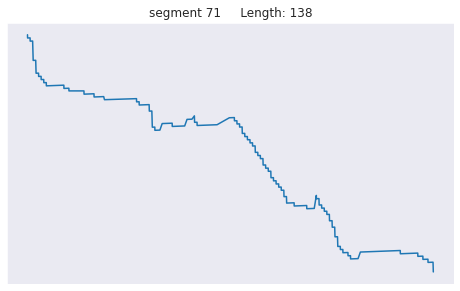

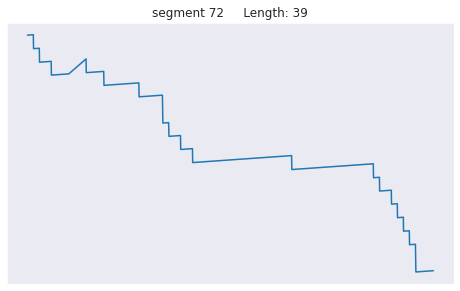

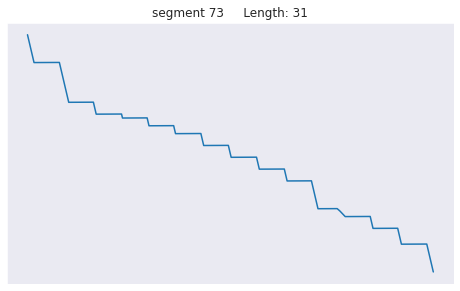

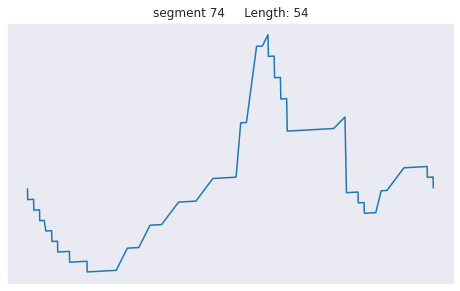

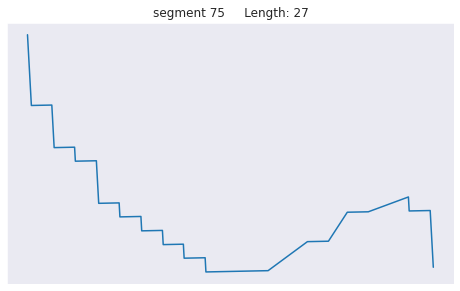

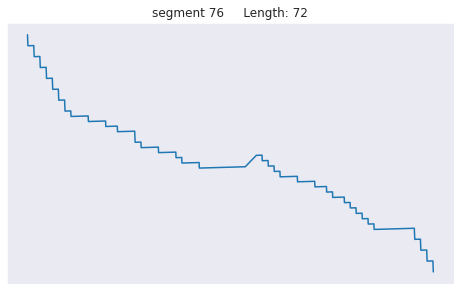

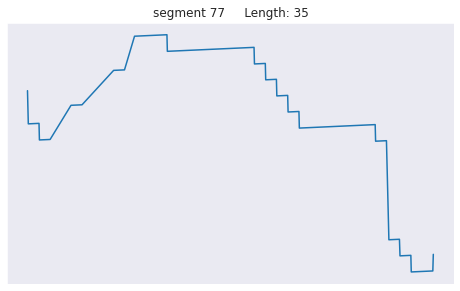

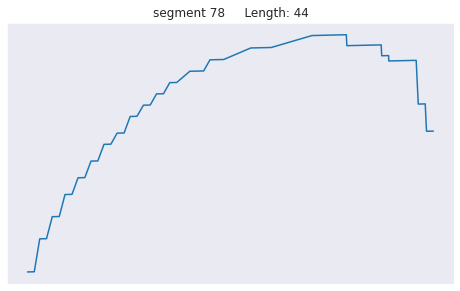

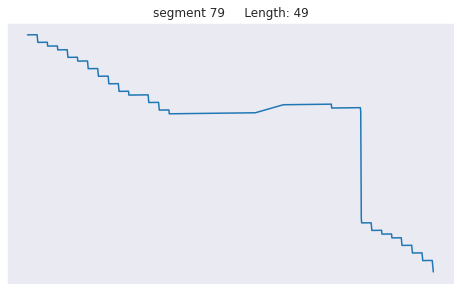

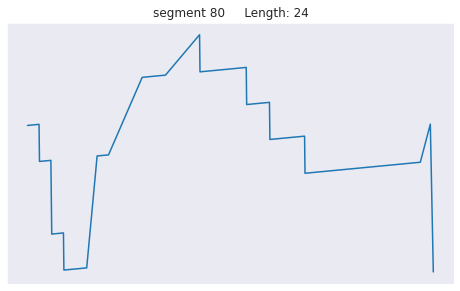

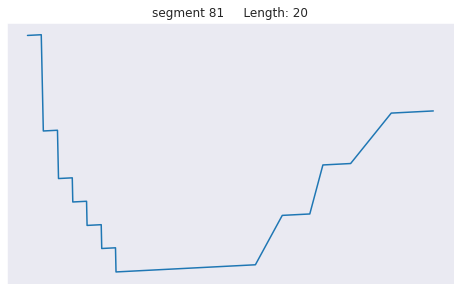

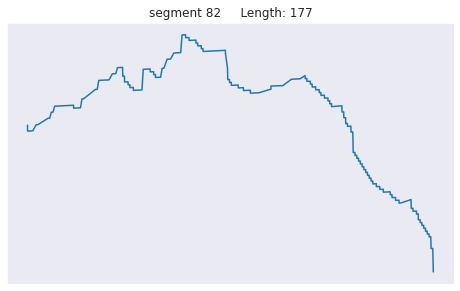

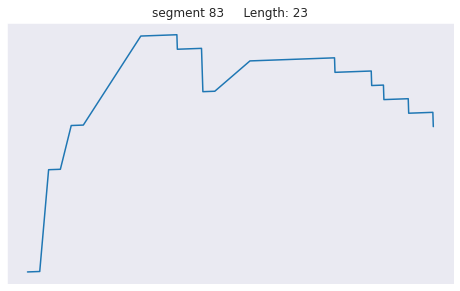

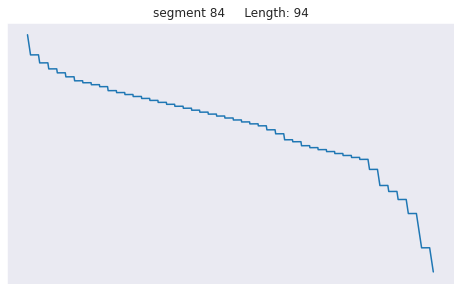

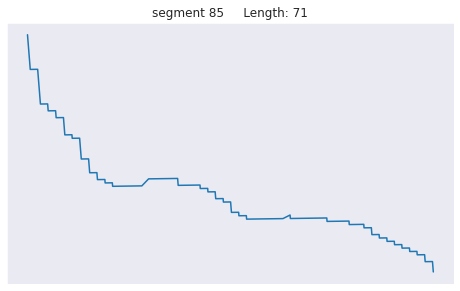

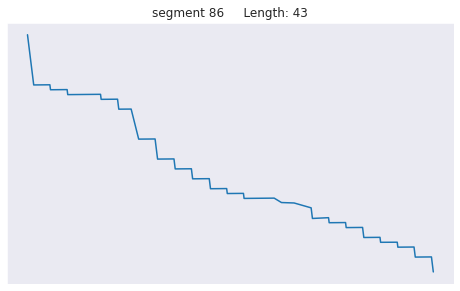

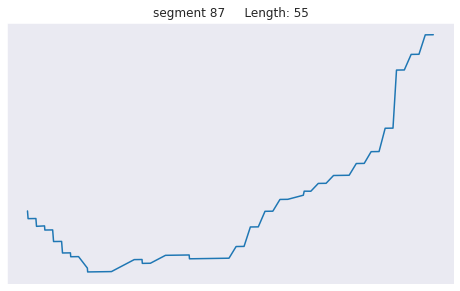

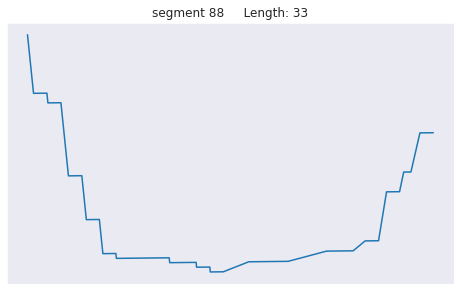

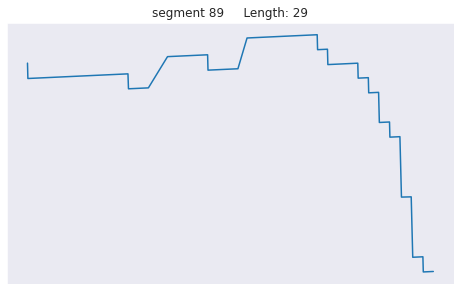

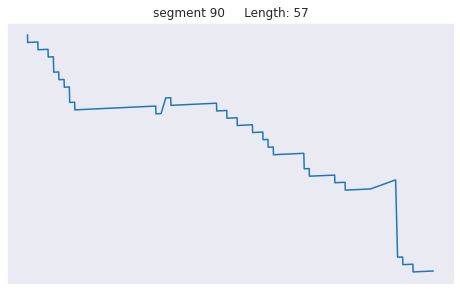

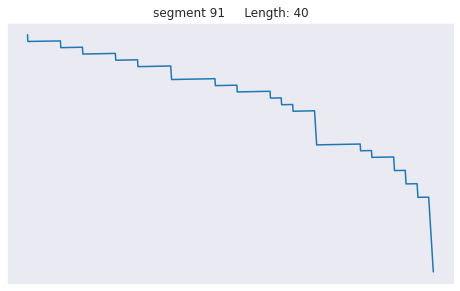

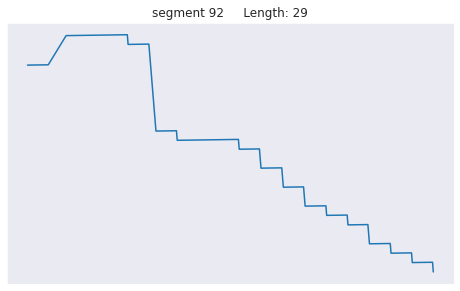

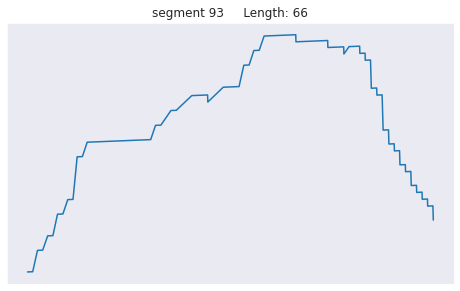

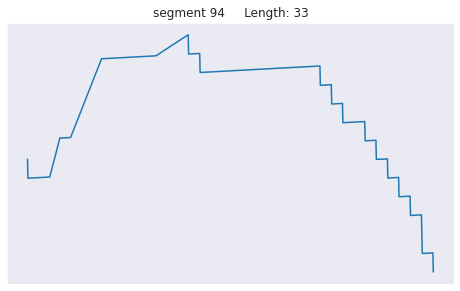

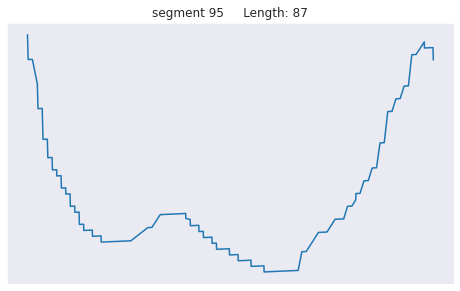

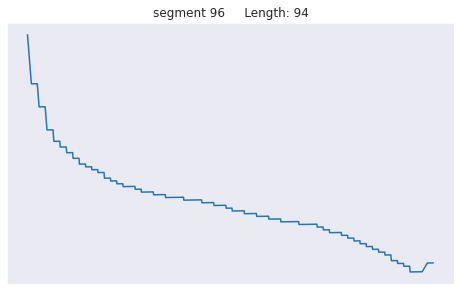

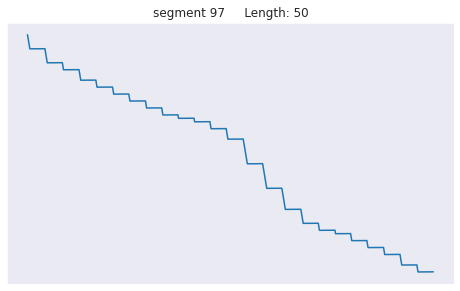

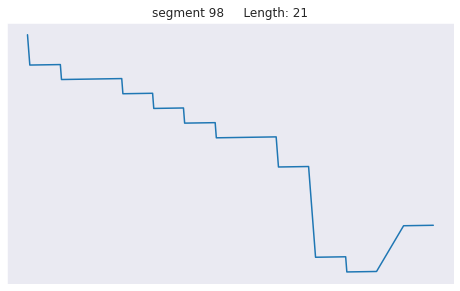

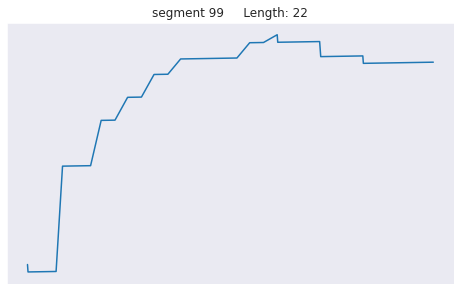

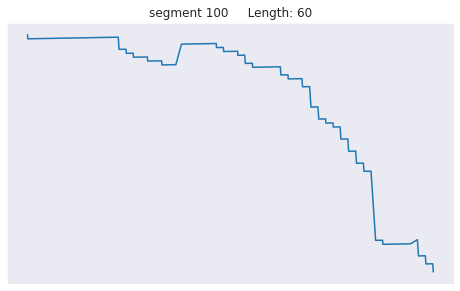

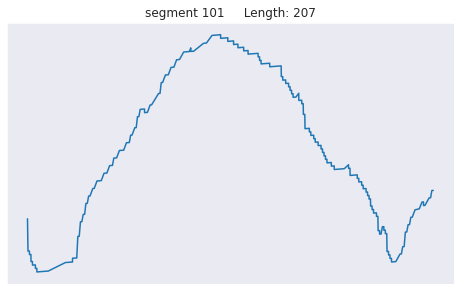

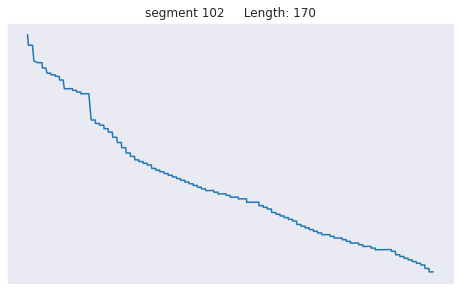

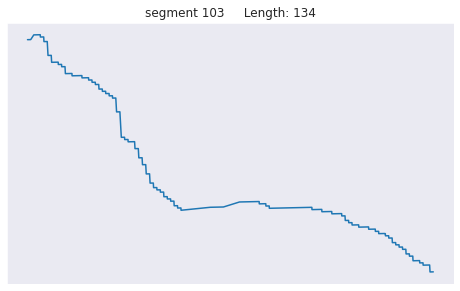

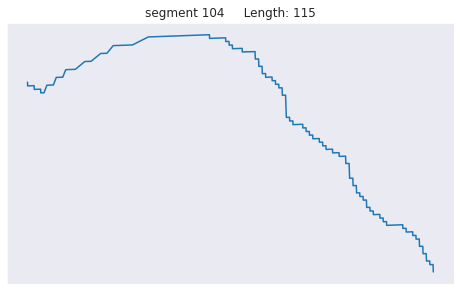

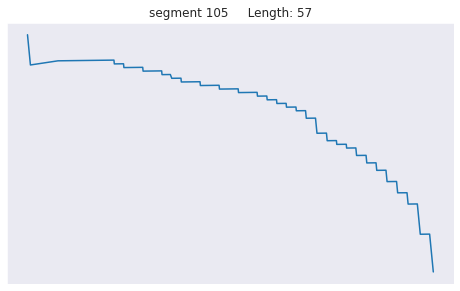

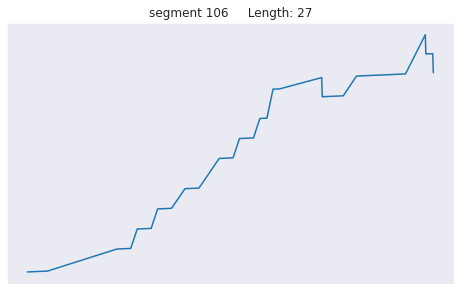

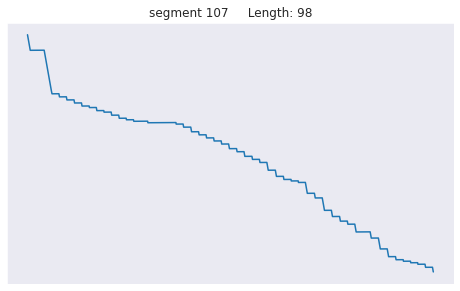

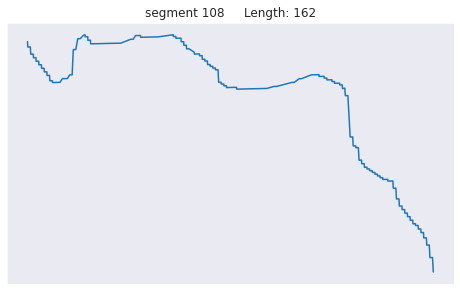

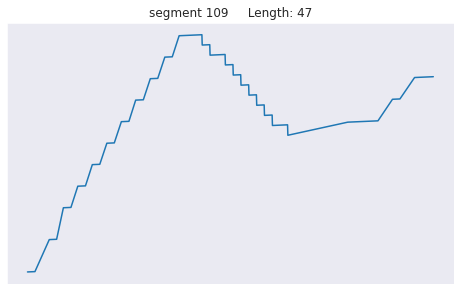

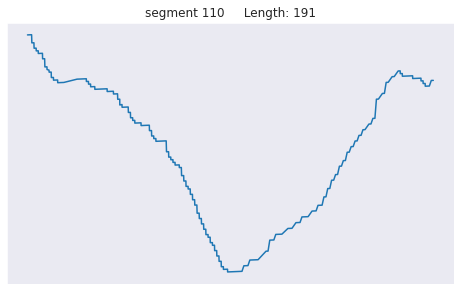

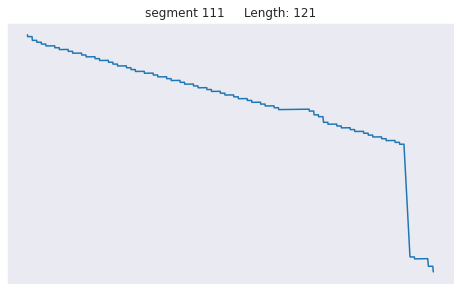

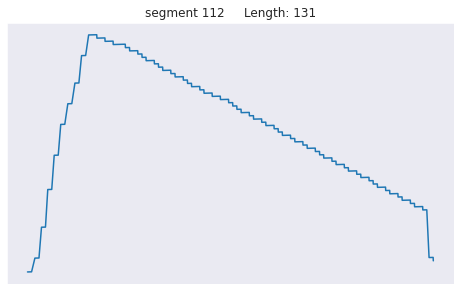

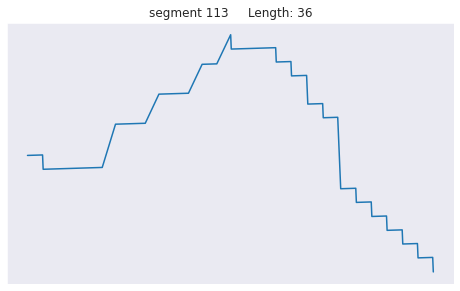

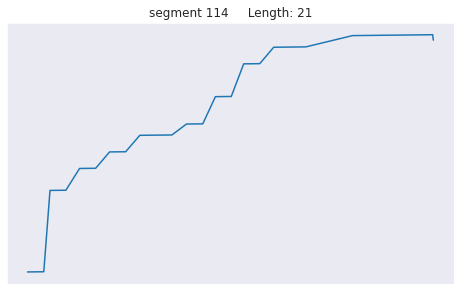

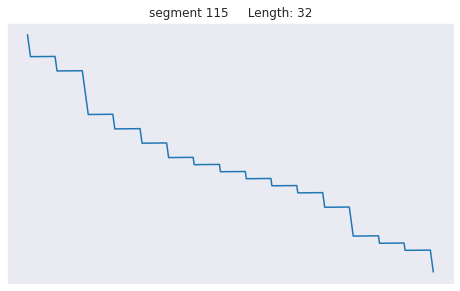

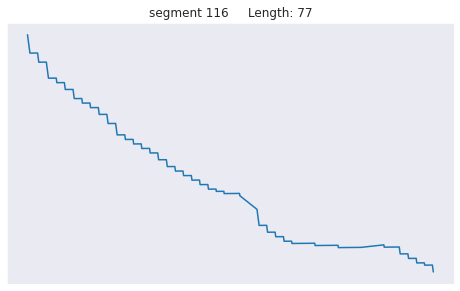

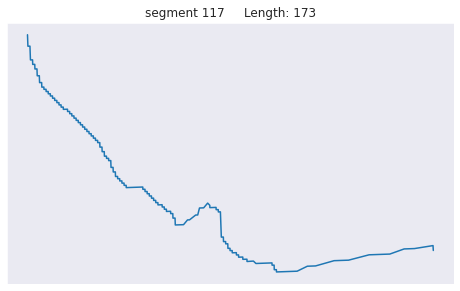

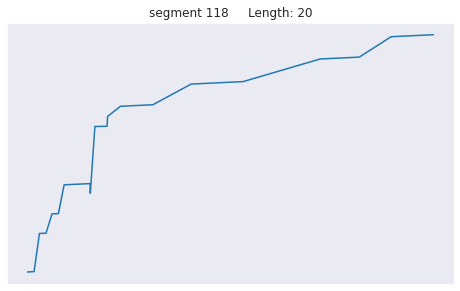

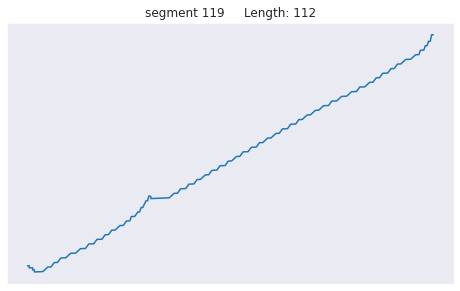

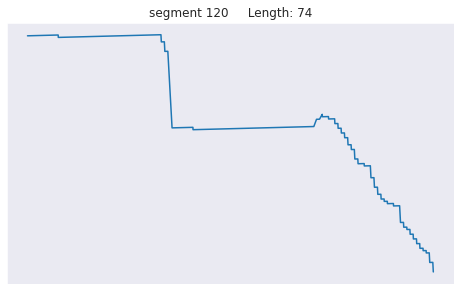

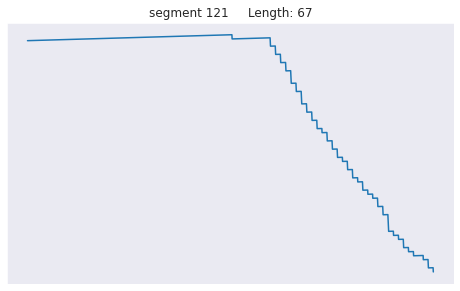

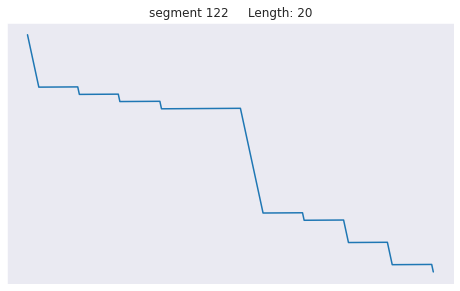

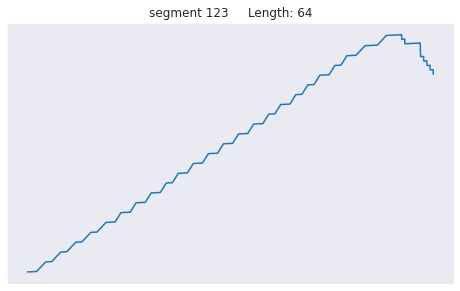

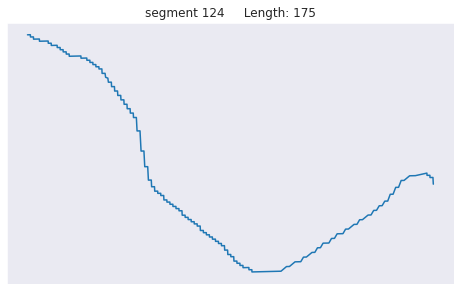

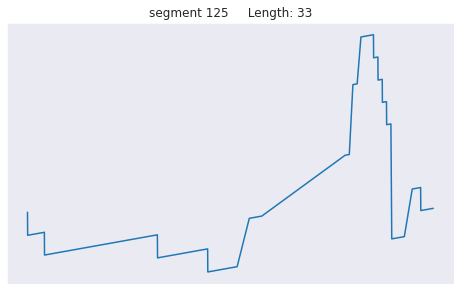

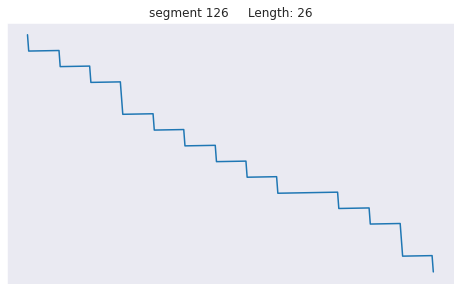

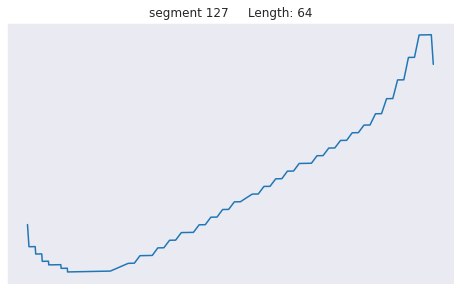

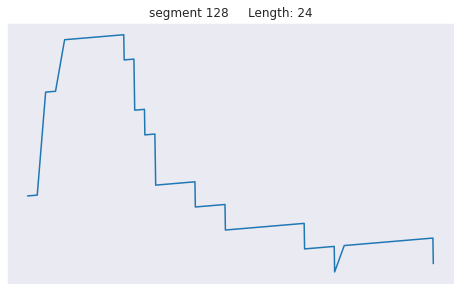

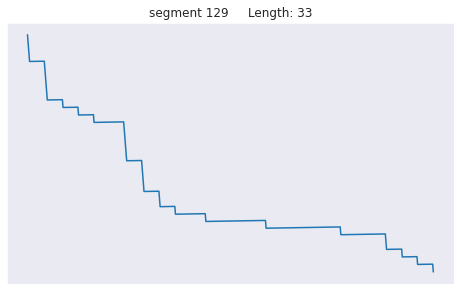

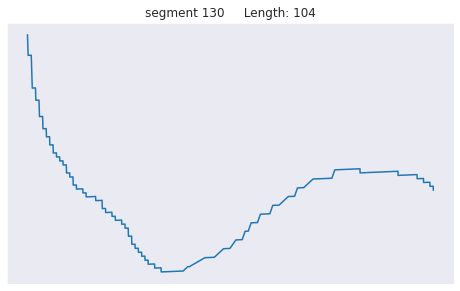

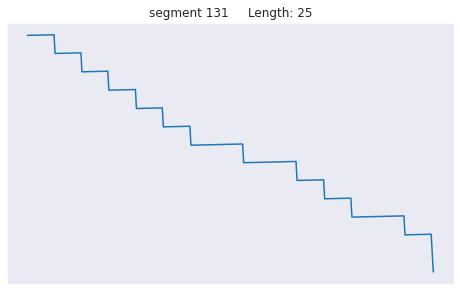

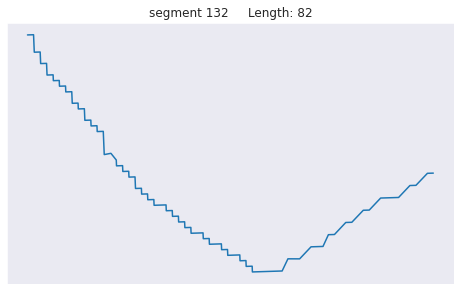

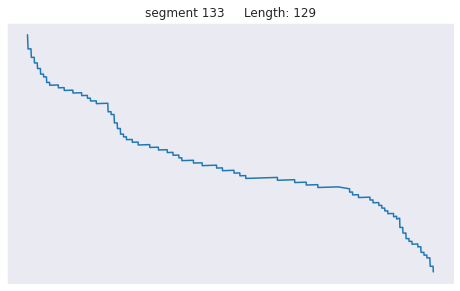

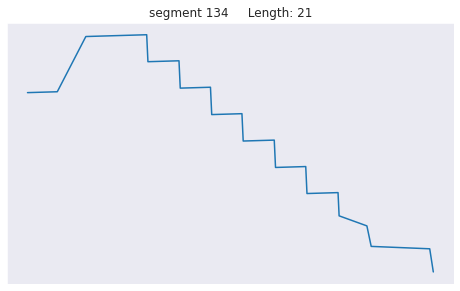

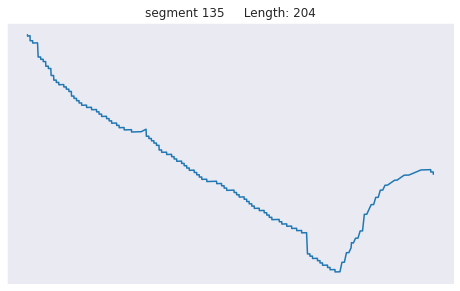

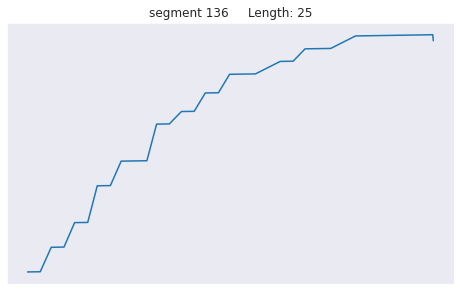

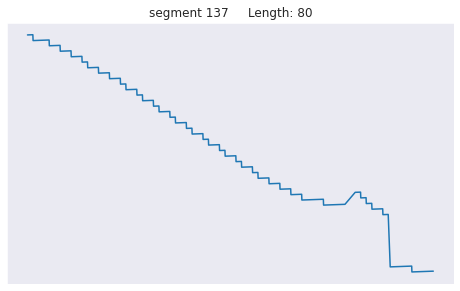

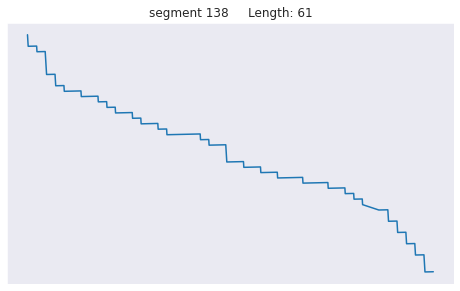

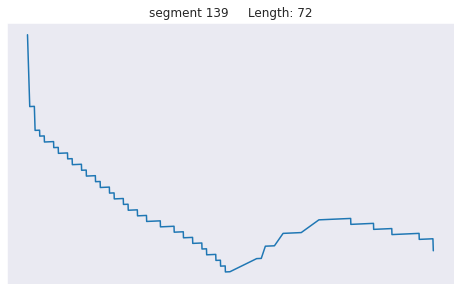

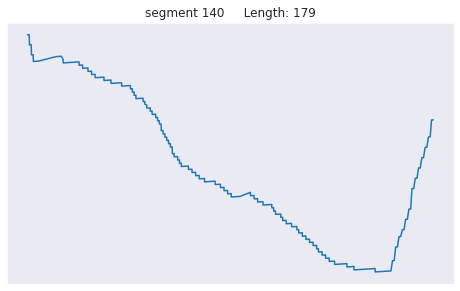

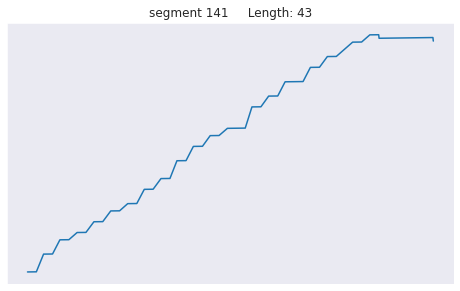

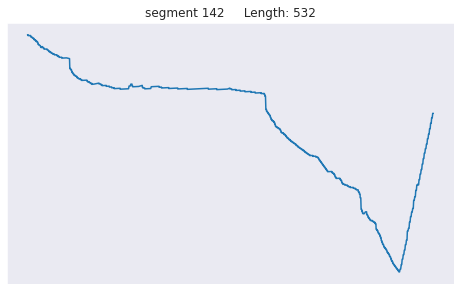

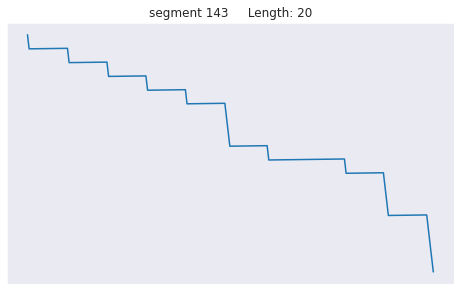

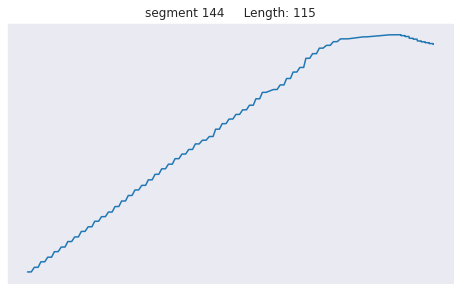

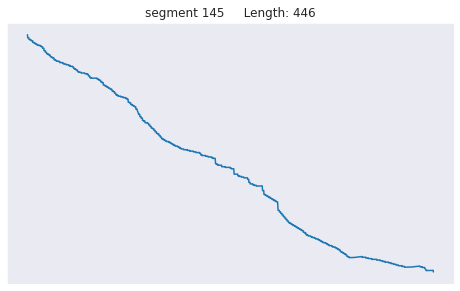

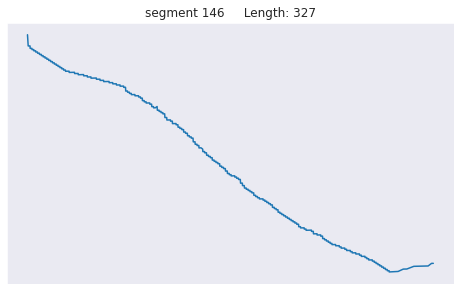

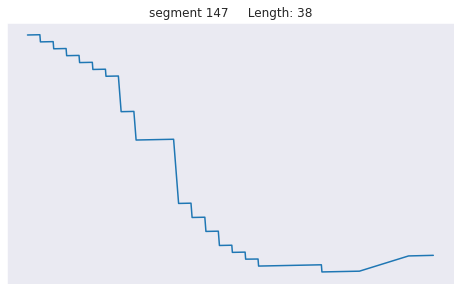

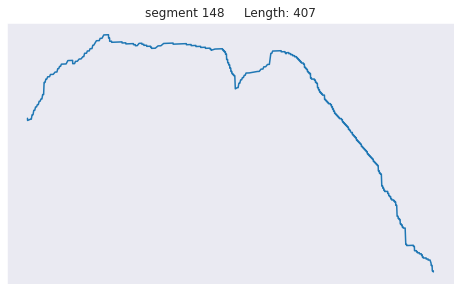

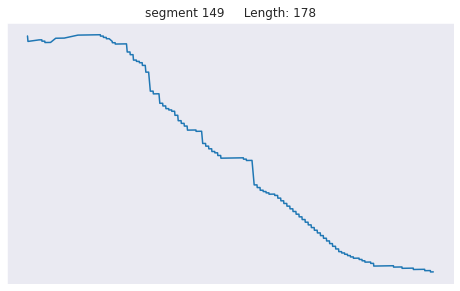

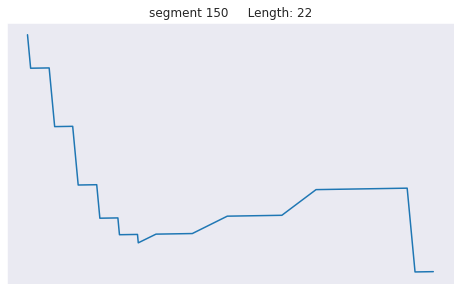

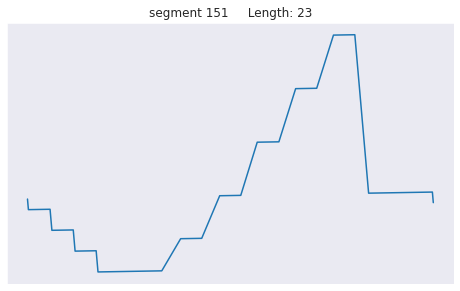

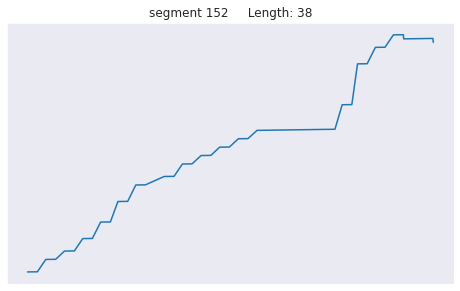

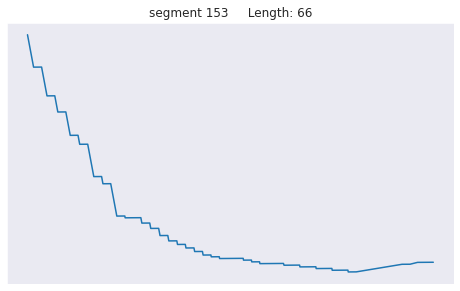

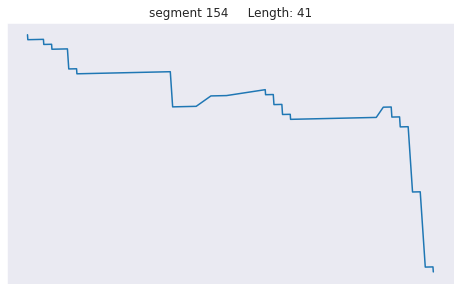

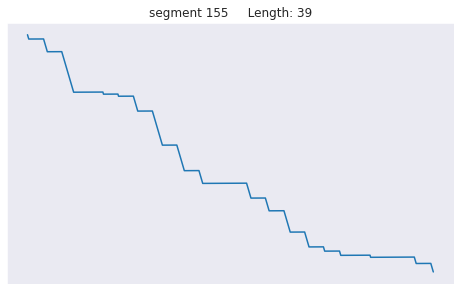

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(eastAndWestList)):
  plotGraph(eastAndWestList[i], 'segment '+ str(i))

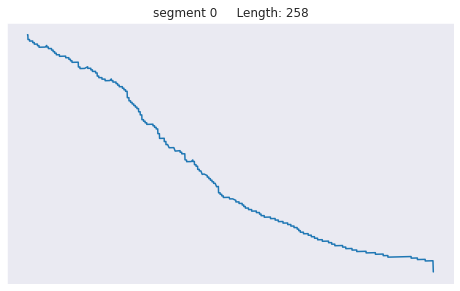

mpf('1.0200309948413633')

In [ ]:
plotGraph(eastAndWestList[0], 'segment '+ str(0))
findDBinarySearch(eastAndWestList[0])

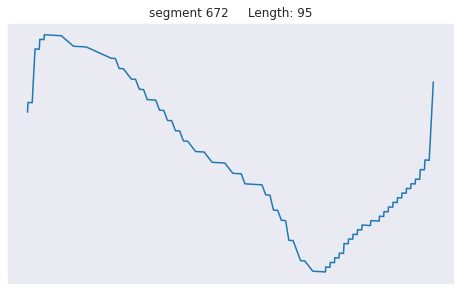

mpf('1.008406365668634')

In [ ]:
i = 672
plotGraph(eastAndWestList[i], 'segment '+ str(i))
findDBinarySearch(eastAndWestList[i])

# Calculating Hausdorff distance (Future Extension, Irrelevant for Now)

In [ ]:
def distanceBetweenTwoPoints1(p1, p2):
  return math.sqrt(((p1.x-p2.x)** 2) + ((p1.y-p2.y)** 2))

In [ ]:
def getDistanceBetweenPointAndSet(point, setB):
  distanceBetweenPointAndSet = float('inf')

  for secondPoint in setB:
    distanceBetweenPointAandB = distanceBetweenTwoPoints1(point, secondPoint)
    distanceBetweenPointAndSet = min(distanceBetweenPointAndSet,distanceBetweenPointAandB)
  return distanceBetweenPointAndSet

In [ ]:
def getDistanceBetweenSetAandB(setA, setB):
  distanceBetweenSetAandB = -float('inf')
  for point in setA:
    distanceBetweenPtToSetB = getDistanceBetweenPointAndSet(point, setB)
    distanceBetweenSetAandB = max(distanceBetweenSetAandB,distanceBetweenPtToSetB)
  return distanceBetweenSetAandB

In [ ]:
def getHausdorffDistance(setA, setB):
  setAtoB = getDistanceBetweenSetAandB(setA, setB)
  setBtoA = getDistanceBetweenSetAandB(setB, setA)

  return (setAtoB, setBtoA)

# First Order Transformation of Set by IFS (Future Extension, Irrelevant for Now)

In [ ]:
def getWnTransformation(pt, a, c, d, e, f, n):
  ptX, ptY = pt.x, pt.y
  an, cn, dn, en, fn = a[n], c[n], d[n], e[n], f[n]

  newX = (an*ptX) + en
  newY = ((cn*ptX)+ (dn*ptY))+ fn

  return CoOrdinates(newX, newY)

In [ ]:
def getFirstOrderTransformationByIFS(setA, a, c, d, e, f):
  finalSet = []
  for pt in setA:
    for idx in range(len(a)):
      wnTransformation = getWnTransformation(pt, a, c, d, e, f, idx)
      finalSet.append(wnTransformation)
  return finalSet

# Distance Between Set and first order transformation of set By IFS (Future Extension, Irrelevant for Now)


In [ ]:
def getHausdorffDistanceBetweenSetAndFirstOrderTransformationOnIFS(setA, a, c, d, e, f):
  setB = getFirstOrderTransformationByIFS(setA, a, c, d, e, f)
  return getHausdorffDistance(setA, setB)

# Get Attractor Of IFS formed by giving Segment as an input (Future Extension, Irrelevant for Now)

In [ ]:
def getAttractor(segment, iters):
  n = len(segment)-1

  a = getAValues(segment)
  d = getDValues(n)
  c = getCValues(segment, d)
  e = getEValues(segment)
  f = getFValues(segment, d)
  p = getPValues(n)

  initial = []


  initial+= segment
  initial = np.array(initial)

  for i in range(iters):
    temp = []
    
    for point in initial:
      x, y = point.x, point.y
      rnd = np.random.choice([i for i in range(n)], p=p)
      nx = a[rnd]*x +e[rnd]
      ny = c[rnd]*x+d[rnd]*y+f[rnd]
      temp.append(CoOrdinates(nx, ny))

    initial = np.array(temp)
  
  return initial

# Distance Between Attractor and Set (Future Extension, Irrelevant for Now)

In [ ]:
def getDistanceBetweenAttractorAndSet(segment, iterations):
  attractor = getAttractor(segment, iterations)
  return getDistanceBetweenSetAandB(segment, attractor)

In [ ]:
print(getDistanceBetweenAttractorAndSet(eastAndWestList[0], 0))

In [ ]:
print(getDistanceBetweenSetAandB(eastAndWestList[0], eastAndWestList[0]))

In [ ]:
for i in range(0,10000, 100):
  print(getDistanceBetweenAttractorAndSet(eastAndWestList[0], i))


In [ ]:
print(getDistanceBetweenAttractorAndSet(eastAndWestList[0], 10000))

In [ ]:
for i in range(5000,11001, 2000):
  print(getDistanceBetweenAttractorAndSet(eastAndWestList[0], i))

In [ ]:
a = getAValues(eastAndWestList[0])
d = getDValues(len(eastAndWestList[0])-1)
c = getCValues(eastAndWestList[0], d)

e = getEValues(eastAndWestList[0])
f = getFValues(eastAndWestList[0], d)

In [ ]:
print(getHausdorffDistanceBetweenSetAndFirstOrderTransformationOnIFS(eastAndWestList[0], a, c, d, e, f))

In [ ]:
print(getHausdorffDistanceBetweenSetAndFirstOrderTransformationOnIFS(eastAndWestList[0], a, c, d, e, f))